# Packages

In [106]:
import json
import pandas as pd
from functools import reduce

In [133]:
import sys, importlib
import os
importlib.reload(sys.modules['edgar_fin_data_services'])
import edgar_fin_data_services as ds

# Load Data of Companies to be analyzed and Define Services

In [130]:
PATH_DATA="/Users/ezratampubolon/PythonProjects/Financial/edgar-data/companyfacts"

In [134]:
# Discover Financial

DiscoverService=ds.generate_fin_analyze_class(cik="0001393612",comp_nm="Discover",path=PATH_DATA)

# Synchrony Financial

SynchronyService=ds.generate_fin_analyze_class(cik="0001601712",comp_nm="Synchrony",path=PATH_DATA)

# American Express

AmexService=ds.generate_fin_analyze_class(cik="0000004962",comp_nm="AmEx",path=PATH_DATA)

# Capital One Financial

CapOneService=ds.generate_fin_analyze_class(cik="0000927628",comp_nm="CapOne",path=PATH_DATA)

## Interest bearing deposit

### Discover Financial

In [135]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="InterestBearingDepositLiabilities",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )

# The data from 2011 to 2013 are missing as they are in another tag:
DiscoverService.add_yearly_data_norm(
    tag="InterestBearingDepositLiabilitiesDomestic",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )

# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
DiscoverService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
DiscoverService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


DiscoverService.dict_df["ib_deposits"]=DiscoverService.dict_df["ib_deposits"].dropna()
DiscoverService.dict_df["ib_deposits"]



,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,70818.000,-6.886667,661.000,0.933379
1,2020,75695.000,4.940881,1231.000,1.626263
2,2019,71955.000,6.769509,1587.000,2.205545
3,2018,67084.000,13.295272,1238.000,1.845447
4,2017,58165.000,11.525832,846.000,1.454483
5,2016,51461.000,8.486038,687.000,1.334992
6,2015,47094.000,2.764683,623.000,1.322886
7,2014,45792.000,2.240566,614.000,1.340846
8,2013,44766.000,6.006791,698.000,1.559219
9,2012,42077.000,6.210043,845.000,2.008223


### Synchrony Financial

In [136]:
# Initialize data
SynchronyService.init_yearly_data_norm(
    tag="InterestBearingDepositLiabilities",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Compute yearly change
SynchronyService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
SynchronyService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
SynchronyService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


SynchronyService.dict_df["ib_deposits"]=SynchronyService.dict_df["ib_deposits"].dropna()
SynchronyService.dict_df["ib_deposits"]




,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,61911.0,-0.901294,566.0,0.914216
1,2020,62469.0,-3.854712,1094.0,1.751269
2,2019,64877.0,1.755630,1566.0,2.413798
3,2018,63738.0,11.707302,1186.0,1.860742
4,2017,56276.0,7.783069,848.0,1.506859
5,2016,51896.0,16.727686,727.0,1.400879
6,2015,43215.0,19.363647,607.0,1.404605
7,2014,34847.0,27.224725,470.0,1.348753


### American Express

In [137]:
# Initialize data
AmexService.init_yearly_data_norm(
    tag="Deposits",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Compute yearly change
AmexService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
AmexService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
AmexService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


AmexService.dict_df["ib_deposits"]=AmexService.dict_df["ib_deposits"].dropna()
AmexService.dict_df["ib_deposits"]


,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,84382.0,-2.954422,458.0,0.542770
1,2020,86875.0,15.640863,943.0,1.085468
2,2019,73287.0,4.539686,1559.0,2.127253
3,2018,69960.0,7.873070,1287.0,1.839623
4,2017,64452.0,17.703097,779.0,1.208651
5,2016,53042.0,-3.685758,598.0,1.127408
6,2015,54997.0,19.684710,475.0,0.863683
7,2014,44171.0,5.451541,373.0,0.844445
8,2013,41763.0,4.693149,442.0,1.058353
9,2012,39803.0,4.786071,480.0,1.205939


### Capital One

In [138]:
# Initialize data
CapOneService.init_yearly_data_norm(
    tag="InterestBearingDepositLiabilities",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )

# Compute yearly change
CapOneService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
CapOneService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
CapOneService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


CapOneService.dict_df["ib_deposits"]=CapOneService.dict_df["ib_deposits"].dropna()
CapOneService.dict_df["ib_deposits"]



,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,272937.0,-0.499383,956.0,0.350264
1,2020,274300.0,12.792927,2165.0,0.789282
2,2019,239209.0,5.404479,3420.0,1.429712
3,2018,226281.0,3.969843,2598.0,1.148130
4,2017,217298.0,2.775911,1602.0,0.737236
5,2016,211266.0,9.178950,1213.0,0.574158
6,2015,191874.0,5.945047,1091.0,0.568602
7,2014,180467.0,-0.782969,1088.0,0.602880
8,2013,181880.0,-4.474379,1241.0,0.682318
9,2012,190018.0,42.139692,1403.0,0.738351


### Comparisons

### Change of Deposits

In [139]:
InterCompanies=ds.InterCompaniesAnalyze(
    [DiscoverService,
    SynchronyService,
    AmexService,
    CapOneService]
    )

In [140]:
InterCompanies.merge_by_quant(
    df_name="ib_deposits", 
    quantity= "interest_bearing_deposit_liabilities_change_in_perc"
    )

InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]=InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"].dropna()
InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]

,year,Discover,Synchrony,AmEx,CapOne
0,2021,-6.886667,-0.901294,-2.954422,-0.499383
1,2020,4.940881,-3.854712,15.640863,12.792927
2,2019,6.769509,1.755630,4.539686,5.404479
3,2018,13.295272,11.707302,7.873070,3.969843
4,2017,11.525832,7.783069,17.703097,2.775911
5,2016,8.486038,16.727686,-3.685758,9.178950
6,2015,2.764683,19.363647,19.684710,5.945047
7,2014,2.240566,27.224725,5.451541,-0.782969


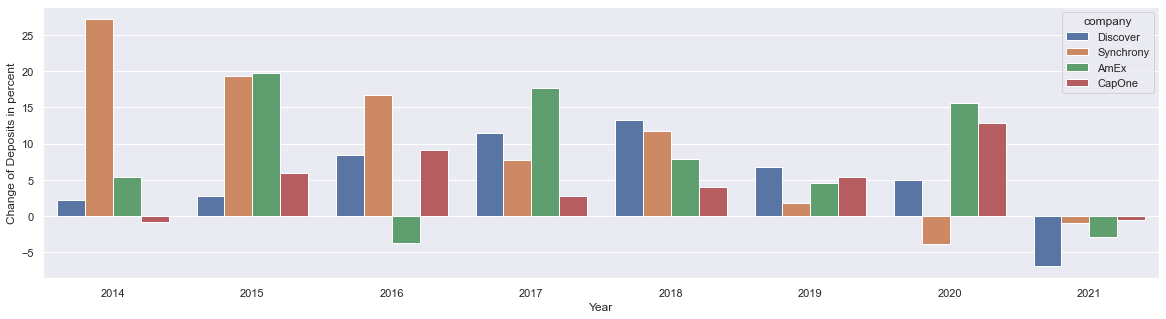

In [141]:
InterCompanies.plot_df(
    key="interest_bearing_deposit_liabilities_change_in_perc", 
    xlabel="Year", 
    ylabel= "Change of Deposits in percent",
    width=20,height=5)

### Interest Rate Deposits

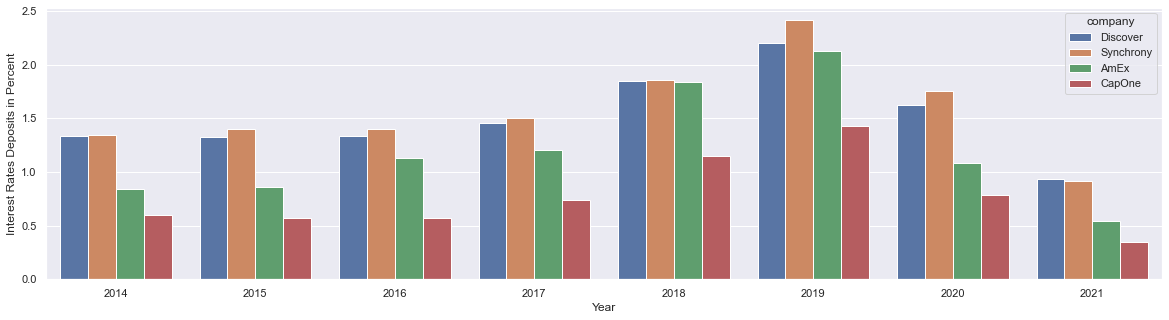

In [142]:
InterCompanies.merge_by_quant(
    df_name="ib_deposits", 
    quantity= "interest_rate_deposits"
    )

InterCompanies.dict_df["interest_rate_deposits"]=InterCompanies.dict_df["interest_rate_deposits"].dropna()
InterCompanies.dict_df["interest_rate_deposits"]


InterCompanies.plot_df(key="interest_rate_deposits", xlabel="Year", ylabel= "Interest Rates Deposits in Percent",width=20,height=5)



## Loans

### Discover

In [143]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="NotesReceivableGross",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# The data is only from 2019 to 2021. So we extract other data
# from other tag:
DiscoverService.add_yearly_data_norm(
    tag="LoansAndLeasesReceivableGrossCarryingAmount",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# The data now is only from 2010. So we extract other data
# from other tag:
DiscoverService.add_yearly_data_norm(
    tag="LoansAndLeasesReceivableConsumer",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# We have multiple data in year 2010. So choose one of them:
DiscoverService.dict_df["loan_receivables"]=DiscoverService.dict_df["loan_receivables"].drop(11).reset_index(drop=True)


# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Add interest loans - Sum of two tags
li_tags=["InterestAndFeeIncomeLoansConsumerInstallmentCreditCard","InterestAndFeeIncomeLoansOtherConsumer"]
[DiscoverService.add_yearly_data_norm(tag=tag,col_nm=tag,df_nm="loan_receivables",add_row=False)for tag in li_tags]
DiscoverService.add_cols(li_col_nm=li_tags,res_col_nm="interest_loans",df_nm="loan_receivables")

# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="interest_loans",
    df_nm="loan_receivables"
    )


# Compute interest rate loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="interest_loans",
    denom_col_nm="loan_receivables",
    res_col_nm="interest_rate_loan_receivables",
    df_nm="loan_receivables"
    )


DiscoverService.dict_df["loan_receivables"]=DiscoverService.dict_df["loan_receivables"].dropna()
DiscoverService.dict_df["loan_receivables"]

,year,loan_receivables,loan_receivables_change_in_perc,interest_loans,interest_loans_change_in_perc,interest_rate_loan_receivables
0,2021,93684.000,3.453098,10451.000,-3.358530,11.155587
1,2020,90449.000,-6.019967,10802.000,-7.026477,11.942642
2,2019,95894.000,5.612447,11561.000,8.649771,12.056020
3,2018,90512.000,6.920629,10561.000,10.358868,11.668066
4,2017,84248.000,8.301681,9467.000,10.045421,11.237062
5,2016,77254.000,6.302586,8516.000,7.597464,11.023377
6,2015,72385.000,3.337708,7869.000,4.562206,10.871037
7,2014,69969.000,5.999800,7510.000,7.123835,10.733325
8,2013,65771.000,5.364066,6975.000,5.275986,10.604978
9,2012,62243.000,8.494128,6607.000,5.055244,10.614848


### Synchrony Financial

In [144]:
# Initialize data
SynchronyService.init_yearly_data_norm(
    tag='LoansAndLeasesReceivableNetOfDeferredIncome',
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Compute yearly change
SynchronyService.compute_row_change(
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Add corresponding interest income
SynchronyService.add_yearly_data_norm(
    tag="InterestAndFeeIncomeLoansAndLeases",
    col_nm="interest_loans",
    df_nm="loan_receivables",
    add_row=False)




# Compute interest rate loan receivables
SynchronyService.compute_ratio(
    numer_col_nm="interest_loans",
    denom_col_nm="loan_receivables",
    res_col_nm="interest_rate_loan_receivables",
    df_nm="loan_receivables"
    )


SynchronyService.dict_df["loan_receivables"]=SynchronyService.dict_df["loan_receivables"].dropna()
SynchronyService.dict_df["loan_receivables"]

,year,loan_receivables,loan_receivables_change_in_perc,interest_loans,interest_rate_loan_receivables
0,2021,80740.0,-1.395838,15228.0,18.860540
1,2020,81867.0,-6.532547,15950.0,19.482820
2,2019,87215.0,-6.792410,18705.0,21.446999
3,2018,93139.0,12.016449,17644.0,18.943729
4,2017,81947.0,6.845888,16219.0,19.792061
5,2016,76337.0,10.541415,14682.0,19.233137
6,2015,68290.0,10.256260,13179.0,19.298580
7,2014,61286.0,6.578990,12216.0,19.932774


### American Express

ToDo: Data not yet complete

### Capital One

In [155]:
# Initialize data
CapOneService.init_yearly_data_norm(
    tag="NotesReceivableGross",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# We extract other data
# from other tag:
CapOneService.add_yearly_data_norm(
    tag="LoansAndLeasesReceivableGrossCarryingAmount",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )



# Compute yearly change
CapOneService.compute_row_change(
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Add corresponding interest income
CapOneService.add_yearly_data_norm(
    tag="InterestAndFeeIncomeLoansAndLeases",
    col_nm="interest_loans",
    df_nm="loan_receivables",
    add_row=False)

# Compute yearly change
CapOneService.compute_row_change(
    col_nm="interest_loans",
    df_nm="loan_receivables"
    )


# Compute interest rate loan receivables
CapOneService.compute_ratio(
    numer_col_nm="interest_loans",
    denom_col_nm="loan_receivables",
    res_col_nm="interest_rate_loan_receivables",
    df_nm="loan_receivables"
    )


CapOneService.dict_df["loan_receivables"]=CapOneService.dict_df["loan_receivables"].dropna()
CapOneService.dict_df["loan_receivables"]

,year,loan_receivables,loan_receivables_change_in_perc,interest_loans,interest_loans_change_in_perc,interest_rate_loan_receivables
0,2021,277340.0,9.272373,24263.0,0.778964,8.748468
1,2020,251624.0,-5.637380,24074.0,-7.427100,9.567450
2,2019,265809.0,7.490341,25862.0,4.384812,9.729543
3,2018,245899.0,-3.486797,24728.0,5.418958,10.056161
4,2017,254473.0,3.492315,23388.0,9.342398,9.190759
5,2016,245586.0,6.407124,21203.0,11.404047,8.633635
6,2015,229851.0,9.369113,18785.0,5.978174,8.172686
7,2014,208316.0,5.336604,17662.0,-3.170649,8.478465
8,2013,197199.0,-4.406716,18222.0,3.720777,9.240412
9,2012,205889.0,33.997445,17544.0,21.460328,8.521096


### Comparison

In [156]:
InterCompanies.merge_by_quant(
    df_name="loan_receivables", 
    quantity= "interest_rate_loan_receivables"
    )

#InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]=InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"].dropna()
InterCompanies.dict_df["interest_rate_loan_receivables"]=InterCompanies.dict_df["interest_rate_loan_receivables"].dropna()
InterCompanies.dict_df["interest_rate_loan_receivables"]

,year,Discover,Synchrony,CapOne
0,2021,11.155587,18.860540,8.748468
1,2020,11.942642,19.482820,9.567450
2,2019,12.056020,21.446999,9.729543
3,2018,11.668066,18.943729,10.056161
4,2017,11.237062,19.792061,9.190759
5,2016,11.023377,19.233137,8.633635
6,2015,10.871037,19.298580,8.172686
7,2014,10.733325,19.932774,8.478465


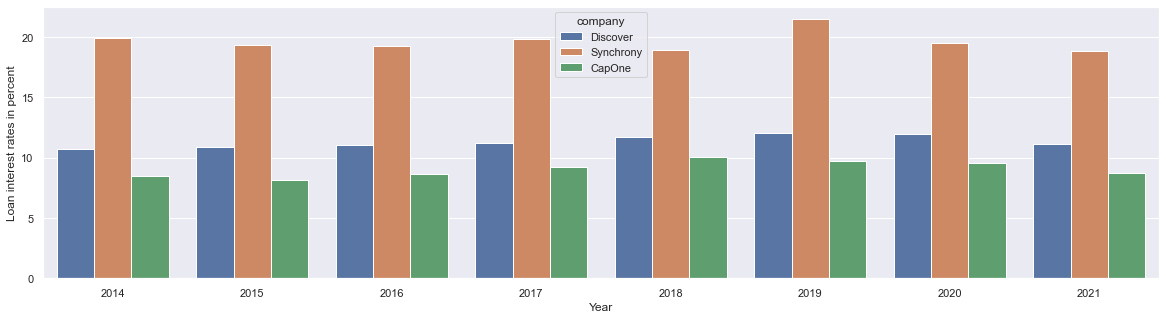

In [157]:
InterCompanies.plot_df(
    key="interest_rate_loan_receivables", 
    xlabel="Year", 
    ylabel='Loan interest rates in percent',
    width=20,height=5)

## Credit Risk

### Discover

In [158]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="ProvisionForLoanLossesExpensed",
    col_nm="provision_for_loan_losses",
    df_nm="loan_losses"
    )


DiscoverService.add_yearly_data_norm(
    tag="FinancingReceivableAllowanceForCreditLossesWriteOffs",
    col_nm="write_offs",df_nm="loan_losses",add_row=False)

DiscoverService.add_yearly_data_norm(
    tag="FinancingReceivableAllowanceForCreditLossesRecovery",
    col_nm="recovery",df_nm="loan_losses",add_row=False)

DiscoverService.dict_df["loan_losses"]["net_write_offs"]=DiscoverService.dict_df["loan_losses"]["write_offs"]-DiscoverService.dict_df["loan_losses"]["recovery"]
DiscoverService.dict_df["loan_losses"]["rem_provision"]=DiscoverService.dict_df["loan_losses"]["provision_for_loan_losses"]-DiscoverService.dict_df["loan_losses"]["net_write_offs"]


DiscoverService.add_data_from_other_col(source_df="loan_receivables",source_col="loan_receivables",target_df="loan_losses")

# Compute the ratio between write offs to loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="write_offs",
    denom_col_nm="loan_receivables",
    res_col_nm="write_offs_to_loan_receivables_perc",
    df_nm="loan_losses"
    )

# Compute the ratio between net write offs to loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="net_write_offs",
    denom_col_nm="loan_receivables",
    res_col_nm="net_write_offs_to_loan_receivables_perc",
    df_nm="loan_losses"
    )

# Compute the ratio between write offs to loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="provision_for_loan_losses",
    denom_col_nm="loan_receivables",
    res_col_nm="provision_to_loan_receivables",
    df_nm="loan_losses"
    )

DiscoverService.dict_df["loan_losses"]=DiscoverService.dict_df["loan_losses"].dropna()
DiscoverService.dict_df["loan_losses"]


,year,provision_for_loan_losses,write_offs,recovery,net_write_offs,rem_provision,loan_receivables,write_offs_to_loan_receivables_perc,net_write_offs_to_loan_receivables_perc,provision_to_loan_receivables
0,2021,227.0,2534.0,903.0,1631.0,-1404.0,93684.000,2.704838,1.740959,0.242304
1,2020,5117.0,3476.0,741.0,2735.0,2382.0,90449.000,3.843050,3.023803,5.657332
2,2019,3231.0,3617.0,731.0,2886.0,345.0,95894.000,3.771873,3.009573,3.369345
3,2018,3035.0,3182.0,570.0,2612.0,423.0,90512.000,3.515556,2.885805,3.353147
4,2017,586.0,2618.0,499.0,2119.0,-1533.0,84248.000,3.107492,2.515193,0.695565
5,2016,1859.0,2034.0,473.0,1561.0,298.0,77254.000,2.632873,2.020607,2.406348
6,2015,1512.0,1855.0,466.0,1389.0,123.0,72385.000,2.562686,1.918906,2.088831
7,2014,1443.0,1806.0,461.0,1345.0,98.0,69969.000,2.581143,1.922280,2.062342
8,2013,1086.0,1739.0,513.0,1226.0,-140.0,65771.000,2.644022,1.864043,1.651184
9,2012,848.0,1909.0,581.0,1328.0,-480.0,62243.000,3.067012,2.133573,1.362402


In [159]:
print(f"Average yearly net Credit Loss: {sum(DiscoverService.dict_df['loan_losses'].rem_provision)/12}")

Average yearly net Credit Loss: -130.0


In [160]:
print(f"Average yearly Net-Write-Offs Rate: {sum(DiscoverService.dict_df['loan_losses']['net_write_offs_to_loan_receivables_perc'])/12}")

Average yearly Net-Write-Offs Rate: 2.8735829550547902


### Synchrony

In [161]:
# Initialize data
SynchronyService.init_yearly_data_norm(
    tag="ProvisionForLoanLossesExpensed",
    col_nm="provision_for_loan_losses",
    df_nm="loan_losses"
    )


SynchronyService.add_yearly_data_norm(
    tag="AllowanceForLoanAndLeaseLossesWriteOffs",
    col_nm="write_offs",df_nm="loan_losses",add_row=False)

SynchronyService.add_yearly_data_norm(
    tag="AllowanceForLoanAndLeaseLossRecoveryOfBadDebts",
    col_nm="recovery",df_nm="loan_losses",add_row=False)

SynchronyService.dict_df["loan_losses"]["net_write_offs"]=SynchronyService.dict_df["loan_losses"]["write_offs"]-SynchronyService.dict_df["loan_losses"]["recovery"]
SynchronyService.dict_df["loan_losses"]["rem_provision"]=SynchronyService.dict_df["loan_losses"]["provision_for_loan_losses"]-SynchronyService.dict_df["loan_losses"]["net_write_offs"]


SynchronyService.add_data_from_other_col(source_df="loan_receivables",source_col="loan_receivables",target_df="loan_losses")

# Compute the ratio between write offs to loan receivables
SynchronyService.compute_ratio(
    numer_col_nm="write_offs",
    denom_col_nm="loan_receivables",
    res_col_nm="write_offs_to_loan_receivables_perc",
    df_nm="loan_losses"
    )

# Compute the ratio between net write offs to loan receivables
SynchronyService.compute_ratio(
    numer_col_nm="net_write_offs",
    denom_col_nm="loan_receivables",
    res_col_nm="net_write_offs_to_loan_receivables_perc",
    df_nm="loan_losses"
    )

# Compute the ratio between write offs to loan receivables
SynchronyService.compute_ratio(
    numer_col_nm="provision_for_loan_losses",
    denom_col_nm="loan_receivables",
    res_col_nm="provision_to_loan_receivables",
    df_nm="loan_losses"
    )

SynchronyService.dict_df["loan_losses"]=SynchronyService.dict_df["loan_losses"].dropna()
SynchronyService.dict_df["loan_losses"]


,year,provision_for_loan_losses,write_offs,recovery,net_write_offs,rem_provision,loan_receivables,write_offs_to_loan_receivables_perc,net_write_offs_to_loan_receivables_perc,provision_to_loan_receivables
0,2021,726.0,3148.0,844.0,2304.0,-1578.0,80740.0,3.898935,2.853604,0.899183
1,2020,5310.0,4606.0,938.0,3668.0,1642.0,81867.0,5.626199,4.480438,6.486130
2,2019,4180.0,6032.0,1027.0,5005.0,-825.0,87215.0,6.916241,5.738692,4.792754
3,2018,5545.0,5544.0,852.0,4692.0,853.0,93139.0,5.952394,5.037632,5.953467
4,2017,5296.0,4998.0,932.0,4066.0,1230.0,81947.0,6.099064,4.961744,6.462714
5,2016,3986.0,3969.0,830.0,3139.0,847.0,76337.0,5.199314,4.112030,5.221583
6,2015,2952.0,3371.0,680.0,2691.0,261.0,68290.0,4.936301,3.940548,4.322741
7,2014,2917.0,3189.0,616.0,2573.0,344.0,61286.0,5.203472,4.198349,4.759651


### Capital One

In [164]:
# Initialize data
CapOneService.init_yearly_data_norm(
    tag="ProvisionForLoanLossesExpensed",
    col_nm="provision_for_loan_losses",
    df_nm="loan_losses"
    )


CapOneService.add_yearly_data_norm(
    tag="AllowanceForLoanAndLeaseLossesWriteOffs",
    col_nm="write_offs",df_nm="loan_losses",add_row=False)

CapOneService.add_yearly_data_norm(
    tag="AllowanceForLoanAndLeaseLossRecoveryOfBadDebts",
    col_nm="recovery",df_nm="loan_losses",add_row=False)

# SynchronyService.dict_df["loan_losses"]["net_write_offs"]=SynchronyService.dict_df["loan_losses"]["write_offs"]-SynchronyService.dict_df["loan_losses"]["recovery"]
# SynchronyService.dict_df["loan_losses"]["rem_provision"]=SynchronyService.dict_df["loan_losses"]["provision_for_loan_losses"]-SynchronyService.dict_df["loan_losses"]["net_write_offs"]


# SynchronyService.add_data_from_other_col(source_df="loan_receivables",source_col="loan_receivables",target_df="loan_losses")

# # Compute the ratio between write offs to loan receivables
# SynchronyService.compute_ratio(
#     numer_col_nm="write_offs",
#     denom_col_nm="loan_receivables",
#     res_col_nm="write_offs_to_loan_receivables_perc",
#     df_nm="loan_losses"
#     )

# # Compute the ratio between net write offs to loan receivables
# SynchronyService.compute_ratio(
#     numer_col_nm="net_write_offs",
#     denom_col_nm="loan_receivables",
#     res_col_nm="net_write_offs_to_loan_receivables_perc",
#     df_nm="loan_losses"
#     )

# # Compute the ratio between write offs to loan receivables
# SynchronyService.compute_ratio(
#     numer_col_nm="provision_for_loan_losses",
#     denom_col_nm="loan_receivables",
#     res_col_nm="provision_to_loan_receivables",
#     df_nm="loan_losses"
#     )

# SynchronyService.dict_df["loan_losses"]=SynchronyService.dict_df["loan_losses"].dropna()
CapOneService.dict_df["loan_losses"]


KeyError: 'AllowanceForLoanAndLeaseLossRecoveryOfBadDebts'

### Comparison

In [97]:
InterCompanies.merge_by_quant(
    df_name="loan_losses", 
    quantity= "net_write_offs_to_loan_receivables_perc"
    )

InterCompanies.dict_df["net_write_offs_to_loan_receivables_perc"]=InterCompanies.dict_df["net_write_offs_to_loan_receivables_perc"].dropna()
InterCompanies.dict_df["net_write_offs_to_loan_receivables_perc"]

,year,discover,synchrony
0,2021,1.740959,2.853604
1,2020,3.023803,4.480438
2,2019,3.009573,5.738692
3,2018,2.885805,5.037632
4,2017,2.515193,4.961744
5,2016,2.020607,4.112030
6,2015,1.918906,3.940548
7,2014,1.922280,4.198349


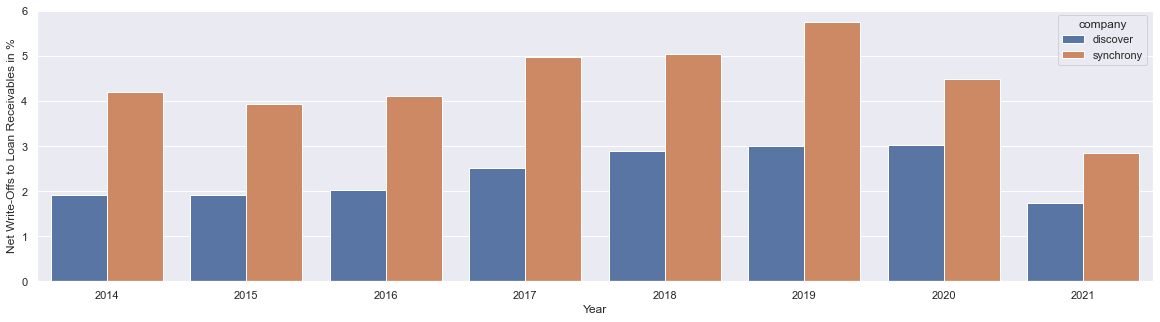

In [99]:
InterCompanies.plot_df(
    key="net_write_offs_to_loan_receivables_perc", 
    xlabel="Year", 
    ylabel='Net Write-Offs to Loan Receivables in %',
    width=20,height=5)

# Cash Flow Analysis

In [545]:
data=dict_fin["discover"]["data"]

In [547]:
df=extract_yearly_data(data,"NetCashProvidedByUsedInOperatingActivities")
df.val=df.val/1000000
df=df.rename(columns={"val":"op_cash_flow"})
df

,year,op_cash_flow
0,2021,6019.000
1,2020,6196.000
2,2019,6196.000
3,2018,5191.000
4,2017,5208.000
5,2016,4425.000
6,2011,3609.615
7,2010,3872.586
8,2009,3597.892
9,2008,4504.159
